In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

# seaborn setting
sns.set()

| Ticker | Sector           |
| ------ | -----            |
|  GC=F  | Gold Feb 23      |
|  GLD   | SPDR Gold Shares |
|  SI=F  | Silver Mar 23    |
|  TLT   | 채권              |
|  XLB   | 소재              |
|  XLE   | 에너지            |
|  XLF   | 금융              |
|  XLI   | 산업재            |
|  XLK   | IT               |
|  XLP   | 필수소비재         |
|  XLU   | 유틸리티           |
|  XLV   | 헬스케어           |
|  XLY   | 임의소비재         |
|  ^GSPC | S&P 500         |

In [89]:
# 티커 리스트 정의
tickers = ['GC=F', 'SI=F', 'TLT', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'SPY']
temp_refs = ['Gold Feb 23', 'Silver Mar 23', '채권', '소재', '에너지', '금융', '산업재', 'IT', '필수소비재', '유틸리티', '헬스케어', '임의소비재', 'SPDR S&P 500 ETF Trust']

refs = {}
for i in range(len(tickers)):
    refs[tickers[i - 1]] = temp_refs[i - 1]

num = len(tickers)

# etf 객체 정의
etf = yf.Tickers(tickers)

# ETF 시계열 가격 데이터 (1달 단위)
data = etf.history(start='2010-01-01', actions=False)['Close'].resample('M').last()

# 매달 수익률 데이터 (1 기준)
rets = data.pct_change().fillna(0) + 1
rets_compare = data.loc['2011-01':].pct_change().fillna(0) + 1

# print(rets_compare)

[*********************100%***********************]  13 of 13 completed


In [90]:
# GSPC 대비 수익률 데이터
rets_rel = rets.copy();

for ticker in tickers :
    for date in rets['SPY'].index :
        rets_rel[ticker][date] = rets[ticker][date] / rets['SPY'][date]

# rets

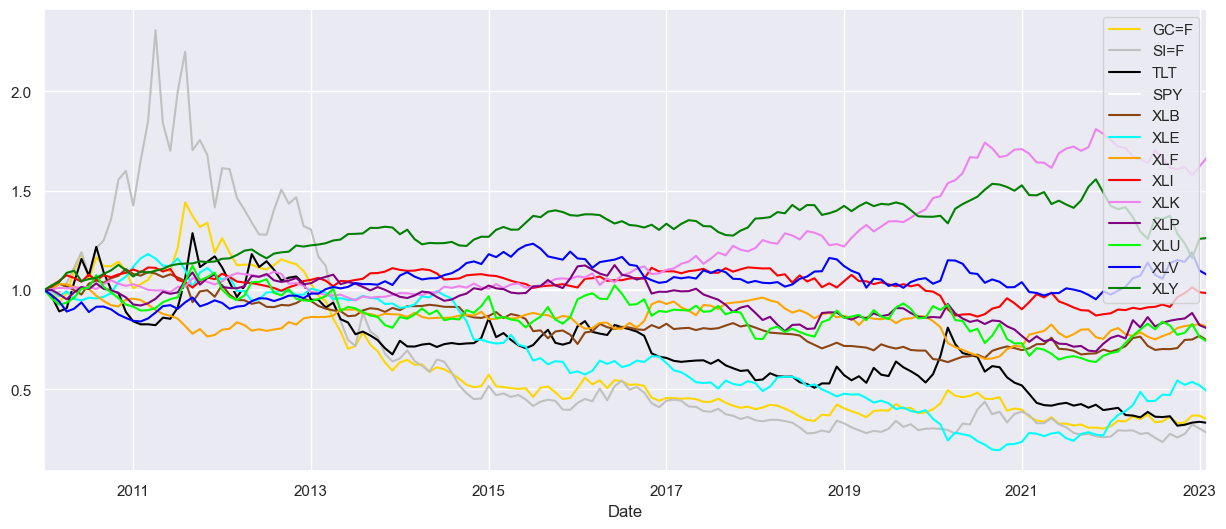

In [91]:
# GSPC 대비 수익률 데이터 누적 후 시각화
rets_rel_cum = rets_rel.copy()
rets_rel_cum = rets_rel_cum.cumprod()

rets_rel_cum['GC=F'].plot(figsize=(15, 6), color='gold')
rets_rel_cum['SI=F'].plot(figsize=(15, 6), color='silver')
rets_rel_cum['TLT'].plot(figsize=(15, 6), color='black')
rets_rel_cum['SPY'].plot(figsize=(15, 6), color='white')
rets_rel_cum['XLB'].plot(figsize=(15, 6), color='saddlebrown')
rets_rel_cum['XLE'].plot(figsize=(15, 6), color='aqua')
rets_rel_cum['XLF'].plot(figsize=(15, 6), color='orange')
rets_rel_cum['XLI'].plot(figsize=(15, 6), color='red')
rets_rel_cum['XLK'].plot(figsize=(15, 6), color='violet')
rets_rel_cum['XLP'].plot(figsize=(15, 6), color='purple')
rets_rel_cum['XLU'].plot(figsize=(15, 6), color='lime')
rets_rel_cum['XLV'].plot(figsize=(15, 6), color='blue')
rets_rel_cum['XLY'].plot(figsize=(15, 6), color='green')
plt.legend()
plt.show()

In [169]:
interval_Absolute = 3
interval_Relative = 3

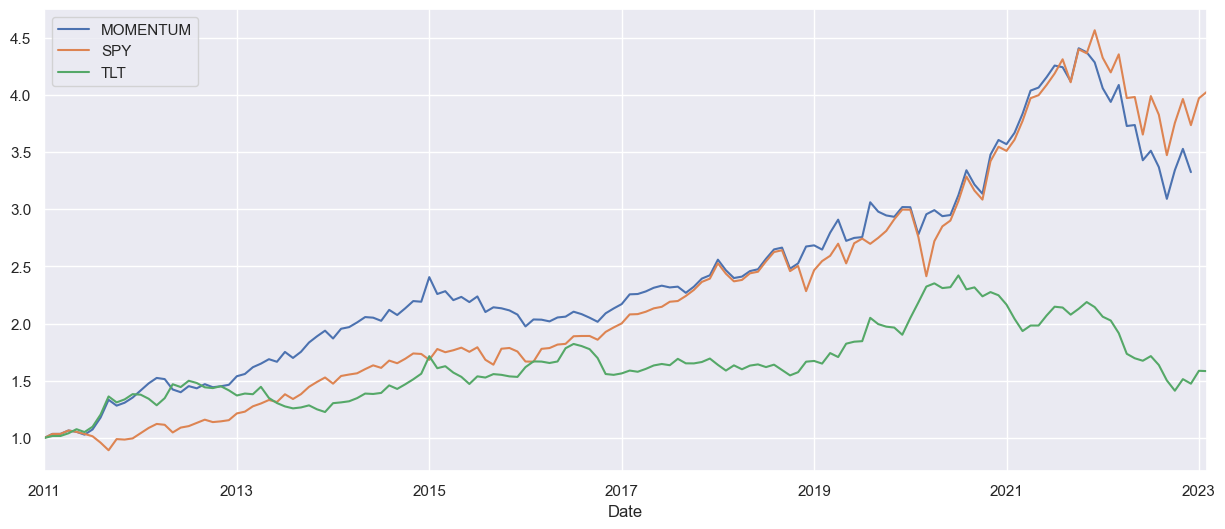

In [170]:
# 모멘텀 전략
rets_momentum = pd.DataFrame(index = rets_compare['SPY'].index, columns = ['MOMENTUM'])

for year in range(2011, 2023) :
    for month in range(1, 13) :
        prev_year = year
        this_year = year
        prev_month = month - interval_Relative
        this_month = month - 1
        if prev_month < 1 :
            prev_month += 12
            prev_year -= 1
            if this_month < 1 :
                this_month += 12
                this_year -= 1
#         print(f'{prev_year}-{month}:' + f'{this_year}-{this_month}:' + f'{year}-{month}')
        if(rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] > rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0]) :
            rets_momentum['MOMENTUM'].loc[f'{year}-{month}'] = rets_compare['SPY'].loc[f'{year}-{month}']
        else :
            rets_momentum['MOMENTUM'].loc[f'{year}-{month}'] = rets_compare['TLT'].loc[f'{year}-{month}']


rets_momentum_cum = rets_momentum.dropna(axis=0).cumprod()
rets_momentum_cum['MOMENTUM'].plot(figsize=(15, 6))
rets_compare['SPY'].cumprod().plot(figsize=(15, 6))
rets_compare['TLT'].cumprod().plot(figsize=(15, 6))
plt.legend()
plt.show()


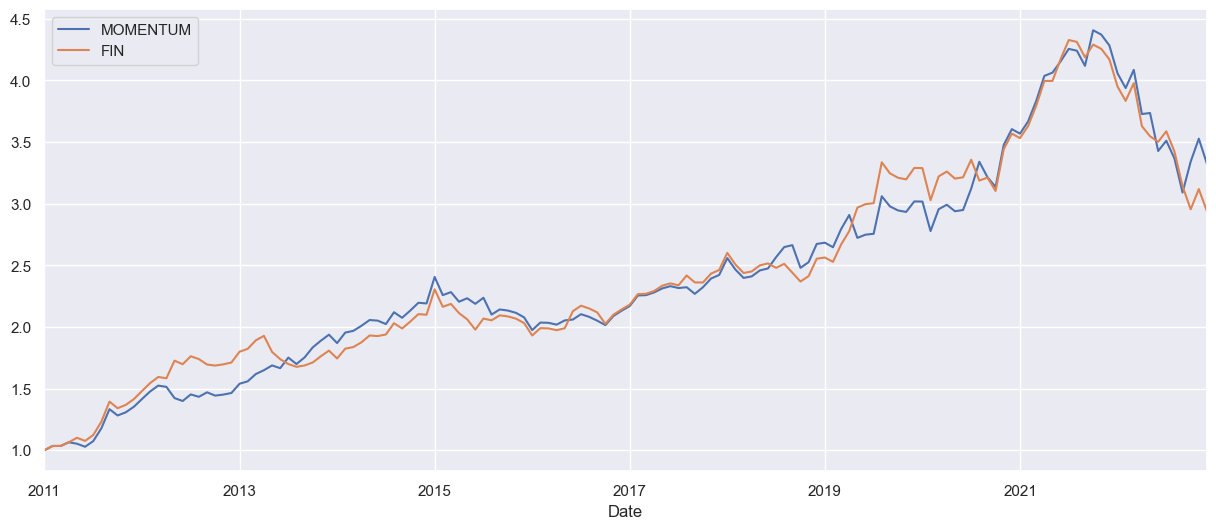

In [171]:
# 모멘텀 전략 + 할로윈 전략
rets_fin = pd.DataFrame(index = rets_momentum['MOMENTUM'].index, columns = ['FIN'])
rets_fin['FIN'] = rets_momentum['MOMENTUM'].copy()

for year in range(2011, 2023) :
    for month in range(5, 11) :
        rets_fin['FIN'].loc[f'{year}-{month}'] = rets['TLT'].loc[f'{year}-{month}']
#         개선되지 않은 할로윈 전략
#         rets_fin['FIN'].loc[f'{year}-{month}'] = 1

rets_fin_cum = rets_fin.dropna(axis=0).cumprod()

rets_momentum_cum['MOMENTUM'].plot(figsize=(15, 6))
rets_fin_cum['FIN'].plot(figsize=(15, 6))
plt.legend()
plt.show()

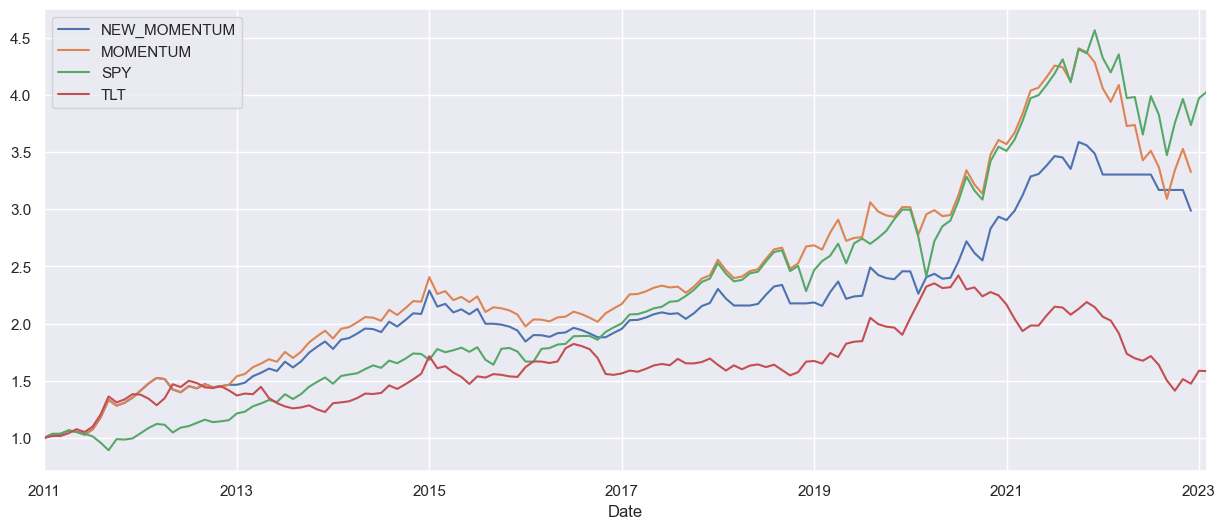

In [173]:
# 개선된 모멘텀 전략
rets_momentum_new = pd.DataFrame(index = rets_compare['SPY'].index, columns = ['NEW_MOMENTUM'])

for year in range(2011, 2023) :
    for month in range(1, 13) :
        prev_year = year
        this_year = year
        prev_month = month - interval_Relative
        this_month = month - 1
        if prev_month < 1 :
            prev_month += 12
            prev_year -= 1
            if this_month < 1 :
                this_month += 12
                this_year -= 1
#         print(f'{prev_year}-{month}:' + f'{this_year}-{this_month}:' + f'{year}-{month}')
        if(rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1 and rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1) :
            rets_momentum_new['NEW_MOMENTUM'].loc[f'{year}-{month}'] = 1
        elif(rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] > rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0]) :
            rets_momentum_new['NEW_MOMENTUM'].loc[f'{year}-{month}'] = rets_compare['SPY'].loc[f'{year}-{month}']
        else :
            rets_momentum_new['NEW_MOMENTUM'].loc[f'{year}-{month}'] = rets_compare['TLT'].loc[f'{year}-{month}']

# 개선된 모멘텀 전략 + 할로윈 전략
rets_fin_new = pd.DataFrame(index = rets_momentum_new['NEW_MOMENTUM'].index, columns = ['NEW_FIN'])
rets_fin_new['NEW_FIN'] = rets_momentum_new['NEW_MOMENTUM'].copy()

for year in range(2011, 2023) :
    for month in range(5, 11) :
        prev_year = year
        this_year = year
        prev_month = month - interval_Relative
        this_month = month - 1
        if prev_month < 1 :
            prev_month += 12
            prev_year -= 1
            if this_month < 1 :
                this_month += 12
                this_year -= 1
        if not (rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1 and rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1) :
            rets_fin_new['NEW_FIN'].loc[f'{year}-{month}'] = rets['TLT'].loc[f'{year}-{month}']

rets_fin_new_cum = rets_fin_new.dropna(axis=0).cumprod()
rets_momentum_new_cum = rets_momentum_new.dropna(axis=0).cumprod()


rets_momentum_new_cum['NEW_MOMENTUM'].plot(figsize=(15, 6))
rets_momentum_cum['MOMENTUM'].plot(figsize=(15, 6))
# rets_fin_new_cum['NEW_FIN'].plot(figsize=(15, 6))
# rets_fin_cum['FIN'].plot(figsize=(15, 6))
rets_compare['SPY'].cumprod().plot(figsize=(15, 6))
rets_compare['TLT'].cumprod().plot(figsize=(15, 6))
plt.legend()
plt.show()

In [166]:
tickers_TLT = ['GC=F', 'SI=F', 'XLU', 'TLT']
tickers_SPY = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLV', 'XLY', 'SPY']

# etf 객체 정의
etf_TLT = yf.Tickers(tickers_TLT)
etf_SPY = yf.Tickers(tickers_SPY)

# ETF 시계열 가격 데이터 (1달 단위)
data_TLT = etf_TLT.history(start='2010-01-01', actions=False)['Close']
data_TLT = data_TLT.resample('M').last()
data_SPY = etf_SPY.history(start='2010-01-01', actions=False)['Close']
data_SPY = data_SPY.resample('M').last()

# 매달 수익률 데이터 (1 기준)
rets_TLT = data_TLT.pct_change().fillna(0) + 1
rets_SPY = data_SPY.pct_change().fillna(0) + 1

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  9 of 9 completed


In [167]:
def get_msr_weights(rets, year, month):

    prev_year = year
    prev_month = month - interval_Absolute
    this_year = year
    this_month = month - 1
    if (prev_month < 1) :
        prev_year -= 1
        prev_month += 12
        if (this_month < 1) :
            this_year -= 1
            this_month += 12
    
    new_rets = rets.loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}']

    # 기대수익률 계산
    er = new_rets.mean(axis=0) * 252 / (12 / interval_Absolute)

    # 공분산행렬 계산
    cov = new_rets.cov() * 252 / (12 / interval_Absolute)

    #자산개수
    noa = er.shape[0]

    #가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    #자산 가중치 상하한
    bounds = ((0.0, 1.0), ) * noa

    #레버리지 불가 제약조건
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    #목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er # 기대수익률
        vol = np.sqrt(weights.T @ cov @ weights) #밑에 참고) 달아놓음 
        return - r / vol #이때 무위험수익률은 0이라고 가정한다다

    #최적화 수행
    res = sco.minimize(neg_sharpe,
                       init_guess,
                       args=(er, cov),
                       method='SLSQP',
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    
    msr_weights_series = pd.Series(res.x, index=np.array(rets.columns))
    
    return msr_weights_series

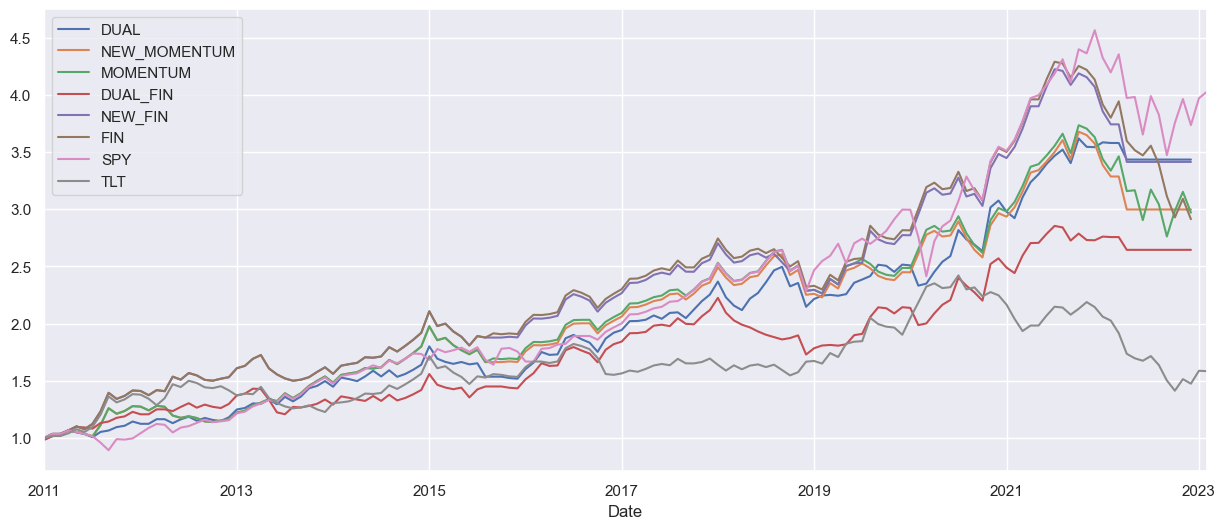

In [168]:
# 듀얼 모멘텀 전략
rets_dual = pd.DataFrame(index = rets_fin_new['NEW_FIN'].index, columns = ["DUAL"])

for year in range(2011, 2023) :
    for month in range(1, 13) :
        prev_year = year
        this_year = year
        prev_month = month - interval_Relative
        this_month = month - 1
        if prev_month < 1 :
            prev_month += 12
            prev_year -= 1
            if this_month < 1 :
                this_month += 12
                this_year -= 1
        
        if(rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1 and rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1) :
            rets_dual['DUAL'].loc[f'{year}-{month}'] = 1
        elif(rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] > rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0]) :
            SPY = get_msr_weights(rets_SPY, year, month)
            tmp = 0
            for ticker in tickers_SPY:
                tmp += rets_SPY.loc[f'{year}-{month}'][ticker] * SPY[ticker]
            rets_dual['DUAL'].loc[f'{year}-{month}'] = tmp[0]
        else :
            TLT = get_msr_weights(rets_TLT, year, month)
            tmp = 0
            for ticker in tickers_TLT:
                tmp += rets_TLT.loc[f'{year}-{month}'][ticker] * TLT[ticker]
            rets_dual['DUAL'].loc[f'{year}-{month}'] = tmp[0]
#             rets_dual['DUAL'].loc[f'{year}-{month}'] = rets['TLT'].loc[f'{year}-{month}']

rets_dual_cum = rets_dual.dropna(axis=0).cumprod()
# print(rets_dual)



# 개선된 모멘텀 전략 + 할로윈 전략
rets_fin_dual = pd.DataFrame(index = rets_dual['DUAL'].index, columns = ['DUAL_FIN'])
rets_fin_dual['DUAL_FIN'] = rets_dual['DUAL'].copy()

for year in range(2011, 2023) :
    for month in range(5, 11) :
        prev_year = year
        this_year = year
        prev_month = month - interval_Relative
        this_month = month - 1
        if prev_month < 1 :
            prev_month += 12
            prev_year -= 1
            if this_month < 1 :
                this_month += 12
                this_year -= 1
        if not (rets['SPY'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1 and rets['TLT'].loc[f'{prev_year}-{prev_month}':f'{this_year}-{this_month}'].cumprod().tail(1)[0] < 1) :
            TLT = get_msr_weights(rets_TLT, year, month)
            tmp = 0
            for ticker in tickers_TLT:
                tmp += rets_TLT.loc[f'{year}-{month}'][ticker] * TLT[ticker]
            rets_fin_dual['DUAL_FIN'].loc[f'{year}-{month}'] = tmp[0]
#             rets_fin_dual['DUAL_FIN'].loc[f'{year}-{month}'] = rets['TLT'].loc[f'{year}-{month}']

rets_fin_dual_cum = rets_fin_dual.dropna(axis=0).cumprod()



rets_dual_cum['DUAL'].plot(figsize=(15, 6))
rets_momentum_new_cum['NEW_MOMENTUM'].plot(figsize=(15, 6))
rets_momentum_cum['MOMENTUM'].plot(figsize=(15, 6))
rets_fin_dual_cum['DUAL_FIN'].plot(figsize=(15, 6))
rets_fin_new_cum['NEW_FIN'].plot(figsize=(15, 6))
rets_fin_cum['FIN'].plot(figsize=(15, 6))
rets_compare['SPY'].cumprod().plot(figsize=(15, 6))
rets_compare['TLT'].cumprod().plot(figsize=(15, 6))
plt.legend()
plt.show()